# Preliminaries
In this lecture, we will understand how to break the resolution limit of the optical microscope imposed by the PSF using the shape of the PSF. This technique is known as "Super-resolution" microscopy, and it revolutionized microscopy in the last two decades. In fact, the scientists who developed some of these techniques won the Nobel prize in Physics some years ago.

# The principle behind super-resolution microscopy
If you know that the image you are looking at consists of individual point-like fluorescent objects, then you can safely assume that each spot will resemble the 2D Gaussian shape we saw two lectures ago. An important property of the Gaussian function is that it is symmetric about the center (provided that the microscope optics are of high quality and aberration free). If this is the case, then it is intuitively clear that **the centroid of the point-like object responsible for the image must be at the centroid of the circular Gaussian intensity pattern**!

The question then is how to find the center of the Guassian intensity pattern. For this, we must learn non-linear least squares curve fitting.

# Linear Regression
This type of data fitting is also known as 'regression analysis'. It's called linear regression, because the fitted parameters (the y_intercept and the slope) appear as simple additions and/or subtractions in the mathematical expression of the model. The experimental variables (x and y in our case) may occur in more complicated forms. e.g. Regression analysis (i.e. curve fitting) using the equation: y = a + b.x^2, which is quadratic in x, is still linear in the fitted parameters.
<br>

Numpy provides a function called 'polyfit' that fits data with polynomial functoins. The [syntax](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html?highlight=polyfit#numpy.polyfit) is pretty straight-forward.  

y = constant + slope*x 

In most cases, we use the method of "[least squares](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line)" fit. This method, minimizes the sum of squared residuals, i.e. the difference between data points and data value predicted by a specific choice of fit parameters. 

This definition is the most widely used in scientific computing (data science people use other types of 'cost functions'). In the case of linear regression, the value of the parameters are determined using the following equations:

\begin{align}
        slope = \frac{[mean(x*y) - mean(x)*mean(y)]}{[mean(x*x)-mean(x)*mean(x)]}
    \end{align}

\begin{align}
        intercept = mean(y) - slope*mean(x)
    \end{align}

# Non-linear regression
When the data arise from a non-linear combination of parameters, they must be fit using the non-linear least-squares fitting procedure. The objective of this procedure is the same - find the parameter combination that minmizes the sum of squared differences between the model and the data. However, the underlying method is quite different and it does not guarantee that it will find the most optimal fit every time. The algorithm is very robust for models involving a few parameters. However, you can help it out by providing a well-reasoned initial guess for the parameter values.

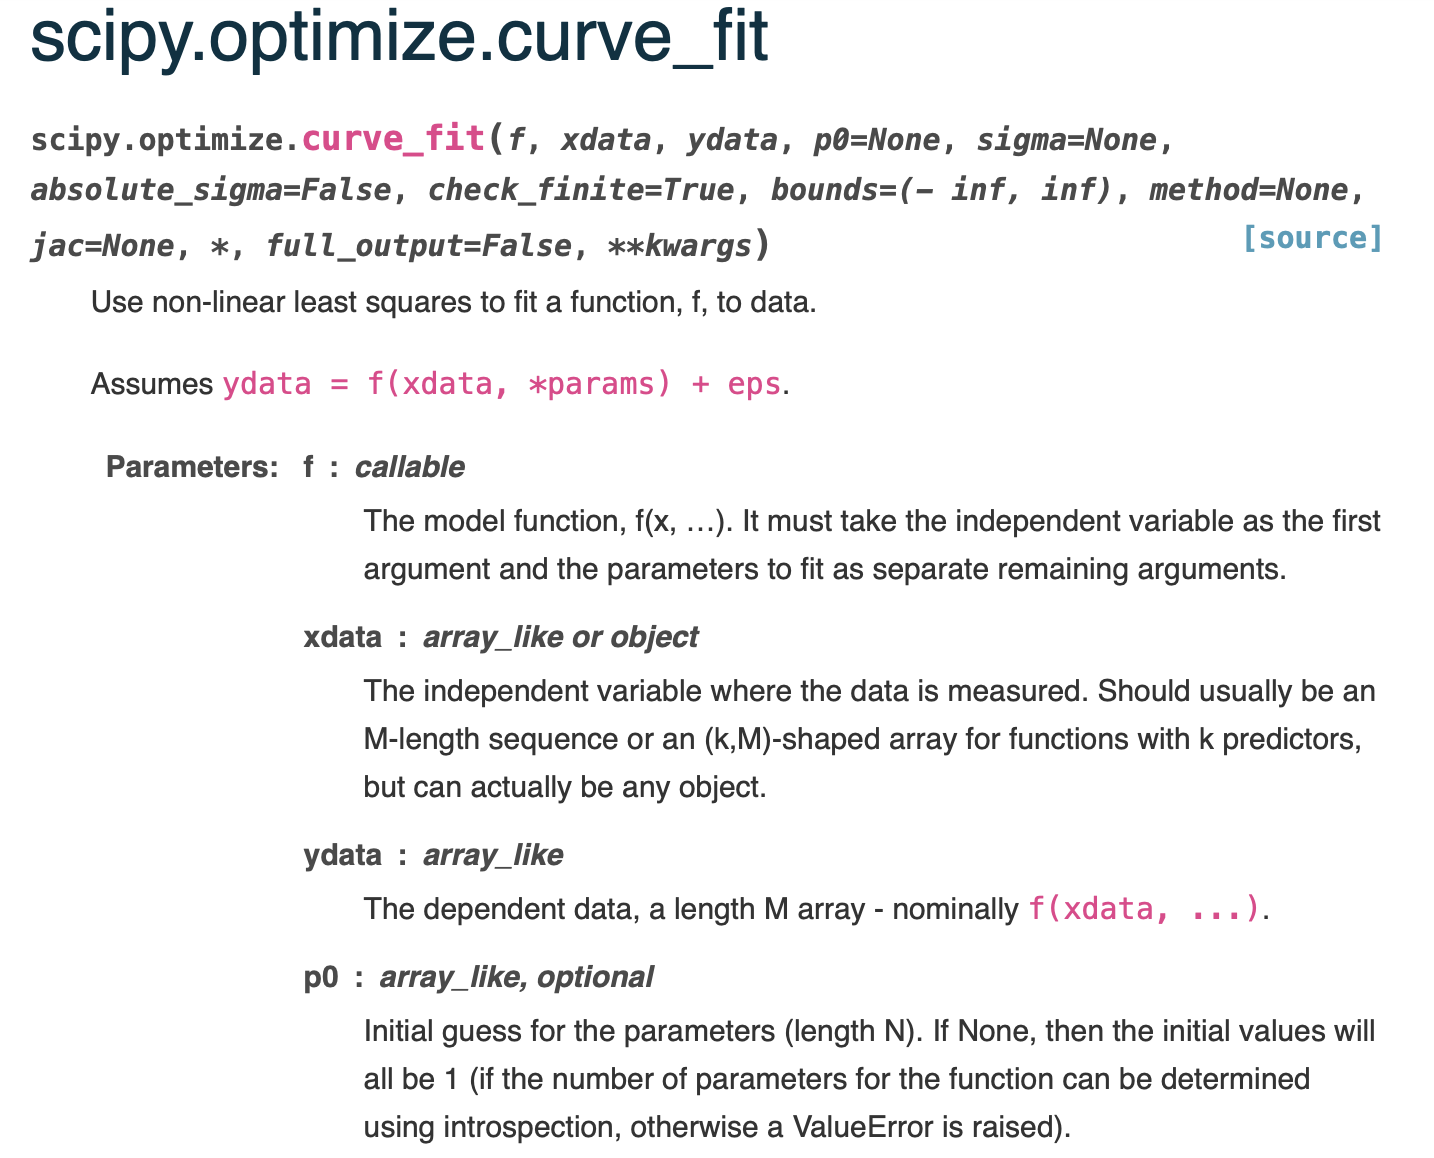

# Writing functions in Python
A function is a user-written command that performs a set of instructions specificed within the body of the function. The function may require one or more inputs (in specific order or paired with a keyword). It may provide an ouptut (e.g. a message printed to the command line, a new variable stored, etc.).

In [ ]:
def printumichid(input1):
  output1 = input1 + '@umich.edu'
  return output1

print(printumichid('ajit'))

def convertTemp(tempinC):
  tempinF = 9/5*tempinC + 32
  return tempinF

convertTemp(0)

In [ ]:
# Definition of the Gaussian function (the bell curve)
def gaussian(x, mean, sigma):
  y = (1/(sqrt(2*pi)*sigma))*np.exp(-np.power(x-mean,2)/(2*sigma**2))
  return y
mean = 5
sigma = 1
x = np.arange(0,10.25,0.25)
y = gaussian(x, mean, sigma) + np.random.normal(0, 0.05, len(x))
plt.plot(x,y)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

img_stack = imread('https://raw.githubusercontent.com/ajitpj/IISER_2023/main/Images/L3/File1_Cy3.tif')

In [ ]:
import scipy.optimize as opt
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

def twoD_GaussianScaledAmp(pos, xo, yo, sigma_x, sigma_y, amplitude, offset, theta):
    """Function to fit, returns 2D gaussian function as 1D array"""
    x,y = pos
    #x = x*np.cos(theta)-y*np.sin(theta)
    #y = x*np.sin(theta)+y*np.cos(theta)
    xo = float(xo)
    yo = float(yo)    
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2);
    b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2);
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2);
    
    #g = offset + amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    g = offset + amplitude*np.exp( - (a*(x-xo)**2 + 2*b*(x-xo)*(y-yo) + c*(y-yo)**2))
    return g.ravel()

def GaussianFitScaledAmp(img):
    """Get FWHM(x,y) of a blob by 2D gaussian fitting
    Parameter:
        img - image as numpy array
    Returns: 
        FWHMs in pixels, along x and y axes.
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, baseline
    initial_guess = (img.shape[1]/2,img.shape[0]/2,2,2,1,0,np.pi/2)
    # subtract background and rescale image into [0,1], with floor clipping
    bg = np.percentile(img,5)
    img_scaled = np.clip((img - bg) / (img.max() - bg),0,1)
    popt, pcov = opt.curve_fit(twoD_GaussianScaledAmp, (x, y), img_scaled.ravel(), p0=initial_guess,
                               bounds = ((img.shape[1]*0.4, img.shape[0]*0.4, .5, .5, 0.5, -0.1, 0), 
                                         (img.shape[1]*0.6, img.shape[0]*0.6, img.shape[1]/2, img.shape[0]/2, 1.5, 0.5, np.pi)))
    return popt, pcov